# **Data loading**

In [ ]:
pip install transformers datasets torch scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from PIL import Image
import numpy as np

In [ ]:
# Select dataset and task
TASK = "sentiment-analysis"  # Options: "sentiment-analysis", "text-classification", "question-answering"
DATASET_NAME = "imdb"  # Replace with your dataset choice

In [ ]:
# Load dataset
print(f"Loading dataset: {DATASET_NAME}")
dataset = load_dataset(DATASET_NAME)

Loading dataset: imdb


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Combine training and testing splits into a single DataFrame
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

In [ ]:
# Add a column to distinguish train and test samples
#train_df["split"] = "train"
#test_df["split"] = "test"

In [ ]:
# Combine both splits
full_df = pd.concat([train_df, test_df], ignore_index=True)

# **Data preprocessing**

In [ ]:
# Handle missing or invalid data
full_df = full_df.dropna(subset=["text"])  # Remove rows with missing text
if "label" in full_df.columns:
    full_df = full_df.dropna(subset=["label"])  # Ensure labels are not missing
    full_df["label"] = full_df["label"].apply(lambda x: int(x) if isinstance(x, (int, float)) else 0)  # Convert labels to int

In [ ]:
# Dataset shape
print("Dataset Shape:", full_df.shape)

Dataset Shape: (50000, 2)


In [ ]:
# Check for duplicates
duplicates = full_df.duplicated(subset=["text"]).sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    full_df = full_df.drop_duplicates(subset=["text"])
    print("Duplicates removed.")

Number of duplicate rows: 418
Duplicates removed.


In [ ]:
# Display dataset summary
print("Dataset Summary:")
print(full_df.info())
print("\nSample Data:")
print(full_df.head())

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    49582 non-null  object
 1   label   49582 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None

Sample Data:
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


# **EDA**


Label Distribution:
label
1    24884
0    24698
Name: count, dtype: int64


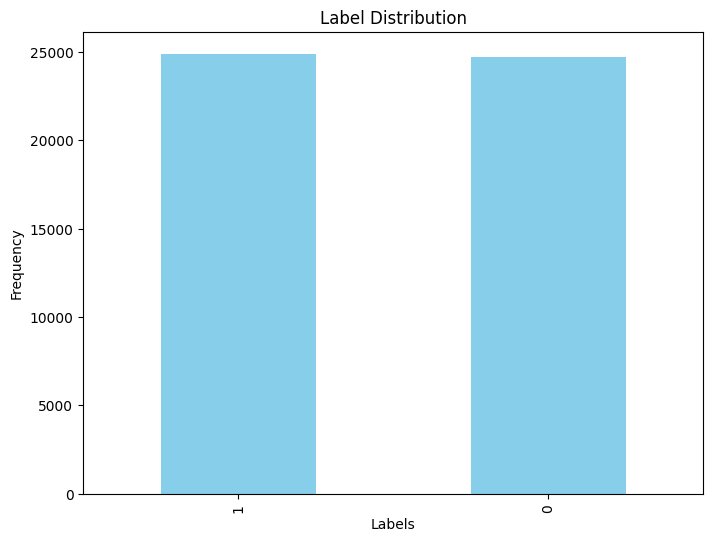

In [ ]:
# Basic EDA
if "label" in full_df.columns:
    print("\nLabel Distribution:")
    print(full_df["label"].value_counts())

    # Plot label distribution
    plt.figure(figsize=(8, 6))
    full_df["label"].value_counts().plot(kind="bar", color="skyblue")
    plt.title("Label Distribution")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.show()


Text Length Statistics:
count    49582.000000
mean      1310.568230
std        990.762238
min         32.000000
25%        699.000000
50%        971.000000
75%       1592.000000
max      13704.000000
Name: text_length, dtype: float64


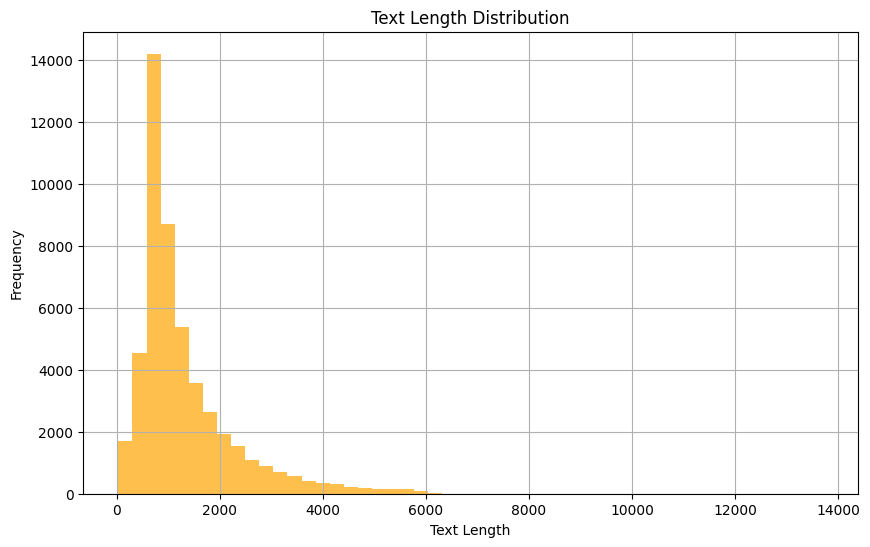

In [ ]:
# Text length analysis
full_df["text_length"] = full_df["text"].apply(lambda x: len(x) if isinstance(x, str) else 0)

print("\nText Length Statistics:")
print(full_df["text_length"].describe())

# Plot text length distribution
plt.figure(figsize=(10, 6))
full_df["text_length"].hist(bins=50, color="orange", alpha=0.7)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Additional EDA
# Check for unique labels
if "label" in full_df.columns:
    unique_labels = full_df["label"].unique()
    print(f"Unique Labels: {unique_labels}")

Unique Labels: [0 1]


In [ ]:
# Text preview of shortest and longest reviews
shortest_text = full_df.loc[full_df["text_length"].idxmin()]
longest_text = full_df.loc[full_df["text_length"].idxmax()]

print("\nShortest Review:")
print(shortest_text["text"])
print(f"Length: {shortest_text['text_length']}")

print("\nLongest Review:")
print(longest_text["text"])
print(f"Length: {longest_text['text_length']}")


Shortest Review:
Read the book, forget the movie!
Length: 32

Longest Review:
Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double s


Correlation between label and text length: 0.02


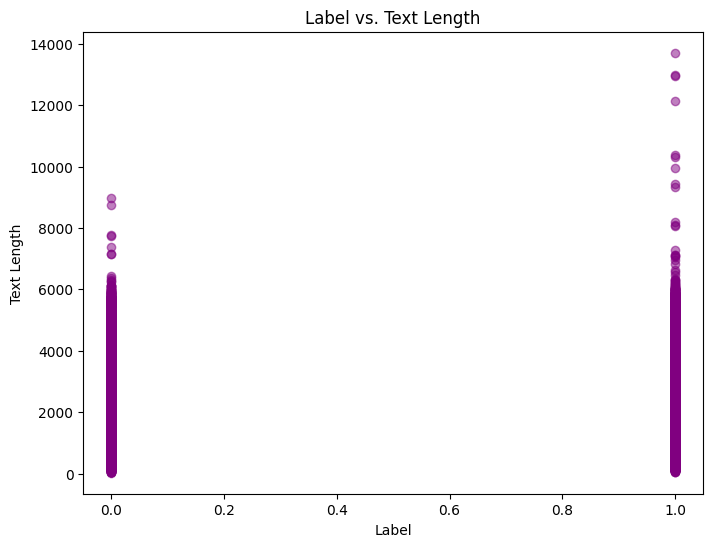

In [ ]:
# Correlation between label and text length
if "label" in full_df.columns:
    correlation = full_df[["label", "text_length"]].corr().iloc[0, 1]
    print(f"\nCorrelation between label and text length: {correlation:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(full_df["label"], full_df["text_length"], alpha=0.5, color="purple")
    plt.title("Label vs. Text Length")
    plt.xlabel("Label")
    plt.ylabel("Text Length")
    plt.show()

Generating word cloud for negative...


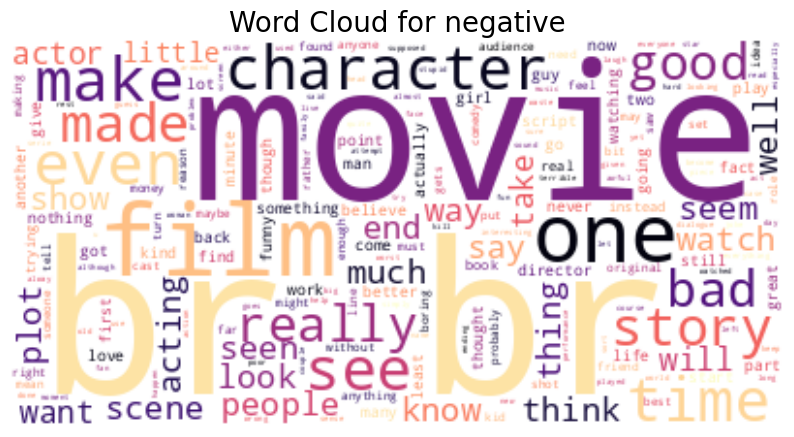

Generating word cloud for positive...


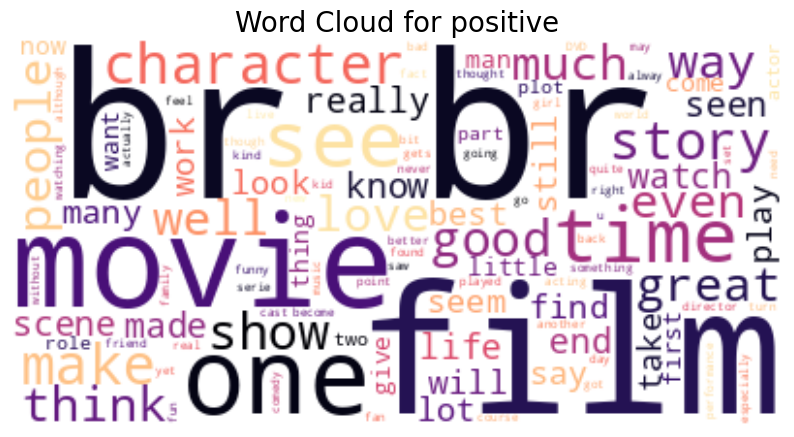

In [ ]:
# Map numeric labels to descriptive ones
label_mapping = {0: "negative", 1: "positive"}

# Generate word clouds for each label
if "label" in full_df.columns:
    for label in unique_labels:
        # Map label to descriptive name
        label_name = label_mapping.get(label, f"label_{label}")
        print(f"Generating word cloud for {label_name}...")

        # Filter text for the current label
        label_text = " ".join(full_df[full_df["label"] == label]["text"].dropna().values)

        # Generate the word cloud
        wordcloud = WordCloud(
            background_color="white",
            max_words=1000,
            stopwords=STOPWORDS,
            colormap="magma"
        ).generate(label_text)

        # Display the word cloud
        plt.figure(figsize=(10, 10))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud for {label_name}", fontsize=20)
        plt.show()

In [ ]:
# Combine train and test datasets
combined_data = pd.concat([train_df, test_df], ignore_index=True)

# Split into new training, validation, and test sets
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42) # Split into train and test
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42) # Split train into train and validation

In [ ]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print("Tokenizing dataset...")

def tokenize_texts(df, tokenizer):
    """
    Tokenizes the text column of a pandas DataFrame.
    """
    tokens = tokenizer(list(df["text"]), truncation=True, padding=True, max_length=512)
    return tokens

train_tokens = tokenize_texts(train_data, tokenizer)
val_tokens = tokenize_texts(val_data, tokenizer)
test_tokens = tokenize_texts(test_data, tokenizer)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_data["text"].tolist(), "label": train_data["label"].tolist(), **train_tokens})
val_dataset = Dataset.from_dict({"text": val_data["text"].tolist(), "label": val_data["label"].tolist(), **val_tokens})

print("Dataset tokenized and ready for model training!")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset...
Dataset tokenized and ready for model training!


# **Model building and Finetuning**

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
import torch
from datasets import Dataset
import numpy as np
import time

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_dict({"text": train_data["text"].tolist(), "label": train_data["label"].tolist(), **train_tokens})
val_dataset = Dataset.from_dict({"text": val_data["text"].tolist(), "label": val_data["label"].tolist(), **val_tokens})

# Select Transformer Models
models = ["bert-base-uncased", "roberta-base", "distilbert-base-uncased", "gpt2"]

# Optimized Training settings
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",        # Save the model after each epoch
    per_device_train_batch_size=16,    # Larger batch size for faster processing
    per_device_eval_batch_size=16,
    num_train_epochs=3,          # Train for 3 epochs
    learning_rate=2e-5,          # Set a lower learning rate
    logging_dir="./logs",
    logging_steps=50,
    warmup_steps=500,            # Add warmup steps
    weight_decay=0.01,           # Apply weight decay
    fp16=True,                   # Enable mixed precision training
    dataloader_num_workers=4,    # Parallel data loading
    gradient_accumulation_steps=2,     # Accumulate gradients over 2 steps
)

for model_name in models:
    print(f"Starting training for {model_name}...")
    start_time = time.time()

    # Load the tokenizer associated with the model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add padding token if it's not defined for GPT2
    if model_name == "gpt2" and tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Load the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, pad_token_id=tokenizer.pad_token_id)

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,            # Add tokenizer to handle special token requirements
    )

    # Train and save the model
    trainer.train()
    model.save_pretrained(f"./models/{model_name}")
    torch.cuda.empty_cache()  # Clear GPU cache

    end_time = time.time()
    print(f"Training for {model_name} completed in {end_time - start_time:.2f} seconds.")

    # Generate predictions for validation dataset
    print(f"Generating predictions for {model_name}...")
    predictions = trainer.predict(val_dataset)
    preds = np.argmax(predictions.predictions, axis=1)

    # Display some examples
    print("Examples of predicted labels:")
    for i in range(5):  # Display 5 examples
        print(f"Text: {val_dataset[i]['text']}")
        print(f"True Label: {val_dataset[i]['label']}")
        print(f"Predicted Label: {preds[i]}")
        print("-" * 50)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Starting training for bert-base-uncased...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-67b80c7d31a6>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same va

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.378000,0.176626


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.378000,0.176626
2,0.189900,0.243192


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training for bert-base-uncased completed in 2671.67 seconds.
Generating predictions for bert-base-uncased...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Examples of predicted labels:
Text: Terrible direction from an awful script. Even the DVD looked muddy and out of focus. Laughable accents all over the map. Unlike most of the other commenters I had no idea this was about boys in love in the mud, but that fact became immediately obvious from the opening scene and all the lovingly drawn-out shots of nude or scantily-clad young men, usually wet or glistening with sweat, looking longingly at each other.
True Label: 0
Predicted Label: 0
--------------------------------------------------
Text: Not much to say other than it is simply a masterpiece. this film contains a myriad of messages that all should take to heart. especially- women do not squelch your man's dreams -honor them -that's why you loved him in the first place! Those who plan for death will live in the grave. Those who carpe diem will awaken those who live in fear. Even our Lord spoke of this when he chastised the the one who buried his talent in fear that he might make a mista

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-67b80c7d31a6>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.912800,0.478029
2,0.526100,0.307817


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

Training for roberta-base completed in 2703.72 seconds.
Generating predictions for roberta-base...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Examples of predicted labels:
Text: Terrible direction from an awful script. Even the DVD looked muddy and out of focus. Laughable accents all over the map. Unlike most of the other commenters I had no idea this was about boys in love in the mud, but that fact became immediately obvious from the opening scene and all the lovingly drawn-out shots of nude or scantily-clad young men, usually wet or glistening with sweat, looking longingly at each other.
True Label: 0
Predicted Label: 0
--------------------------------------------------
Text: Not much to say other than it is simply a masterpiece. this film contains a myriad of messages that all should take to heart. especially- women do not squelch your man's dreams -honor them -that's why you loved him in the first place! Those who plan for death will live in the grave. Those who carpe diem will awaken those who live in fear. Even our Lord spoke of this when he chastised the the one who buried his talent in fear that he might make a mista

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-67b80c7d31a6>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.437200,0.195856
2,0.241300,0.235922


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

Training for distilbert-base-uncased completed in 1283.19 seconds.
Generating predictions for distilbert-base-uncased...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Examples of predicted labels:
Text: Terrible direction from an awful script. Even the DVD looked muddy and out of focus. Laughable accents all over the map. Unlike most of the other commenters I had no idea this was about boys in love in the mud, but that fact became immediately obvious from the opening scene and all the lovingly drawn-out shots of nude or scantily-clad young men, usually wet or glistening with sweat, looking longingly at each other.
True Label: 0
Predicted Label: 0
--------------------------------------------------
Text: Not much to say other than it is simply a masterpiece. this film contains a myriad of messages that all should take to heart. especially- women do not squelch your man's dreams -honor them -that's why you loved him in the first place! Those who plan for death will live in the grave. Those who carpe diem will awaken those who live in fear. Even our Lord spoke of this when he chastised the the one who buried his talent in fear that he might make a mista

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-20-67b80c7d31a6>:47: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.080400,0.522842
2,0.668400,0.352038


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

Training for gpt2 completed in 3846.61 seconds.
Generating predictions for gpt2...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Examples of predicted labels:
Text: Terrible direction from an awful script. Even the DVD looked muddy and out of focus. Laughable accents all over the map. Unlike most of the other commenters I had no idea this was about boys in love in the mud, but that fact became immediately obvious from the opening scene and all the lovingly drawn-out shots of nude or scantily-clad young men, usually wet or glistening with sweat, looking longingly at each other.
True Label: 0
Predicted Label: 0
--------------------------------------------------
Text: Not much to say other than it is simply a masterpiece. this film contains a myriad of messages that all should take to heart. especially- women do not squelch your man's dreams -honor them -that's why you loved him in the first place! Those who plan for death will live in the grave. Those who carpe diem will awaken those who live in fear. Even our Lord spoke of this when he chastised the the one who buried his talent in fear that he might make a mista

# **Evaluation Metrics**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import time
import os
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from datasets import Dataset
import torch
import pandas as pd  # Import pandas for tabular display

In [ ]:
def get_model_size(model_name):
    """
    Calculates the size of a model in MB.
    """
    model_dir = f"./models/{model_name}"
    total_size = sum(os.path.getsize(os.path.join(model_dir, f)) for f in os.listdir(model_dir)) / (1024 * 1024)
    return total_size

In [ ]:
def evaluate_model(model_name, test_data):
    """
    Evaluates a model on accuracy, F1 score, inference time, and calculates its size.
    """
    model = AutoModelForSequenceClassification.from_pretrained(f"./models/{model_name}")
    trainer = Trainer(model=model)
    # Convert test_data to a Hugging Face Dataset to match the training format
    test_dataset = Dataset.from_pandas(test_data)

    # Tokenize the test dataset using the model's tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add padding token if it's not defined for GPT2
    if model_name == "gpt2" and tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

    test_dataset = test_dataset.map(preprocess_function, batched=True)

    # Timing inference
    start_time = time.time()
    predictions = trainer.predict(test_dataset)
    inference_time = time.time() - start_time

    preds = torch.argmax(torch.tensor(predictions.predictions), axis=1)
    labels = torch.tensor(predictions.label_ids)

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")

    # Get model size in MB
    model_size = get_model_size(model_name)

    return {"Model": model_name, "Accuracy": acc, "F1 Score": f1,
            "Inference Time (s)": inference_time, "Model Size (MB)": model_size}

In [ ]:
# Evaluate models
results = []
for model_name in models:
    results.append(evaluate_model(model_name, test_data))

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

# Display the results in tabular form
print("Performance Metrics for Each Model:")
print(results_df.to_string(index=False))  # Display without the DataFrame index

Performance Metrics for Each Model:
                  Model  Accuracy  F1 Score  Inference Time (s)  Model Size (MB)
      bert-base-uncased    0.9433  0.943302           79.583983       417.670608
           roberta-base    0.4943  0.327152           75.030240       475.514945
distilbert-base-uncased    0.9329  0.932902           41.457199       255.425620
                   gpt2    0.5162  0.392532          132.352605       474.721362


# **Comparing the models**

In [ ]:
# Extract metrics
model_names = [result['Model'] for result in results]  # Get model names from the list of dictionaries
accuracies = [result["Accuracy"] for result in results]
f1_scores = [result["F1 Score"] for result in results]
times = [result["Inference Time (s)"] for result in results]
sizes = [result["Model Size (MB)"] for result in results]

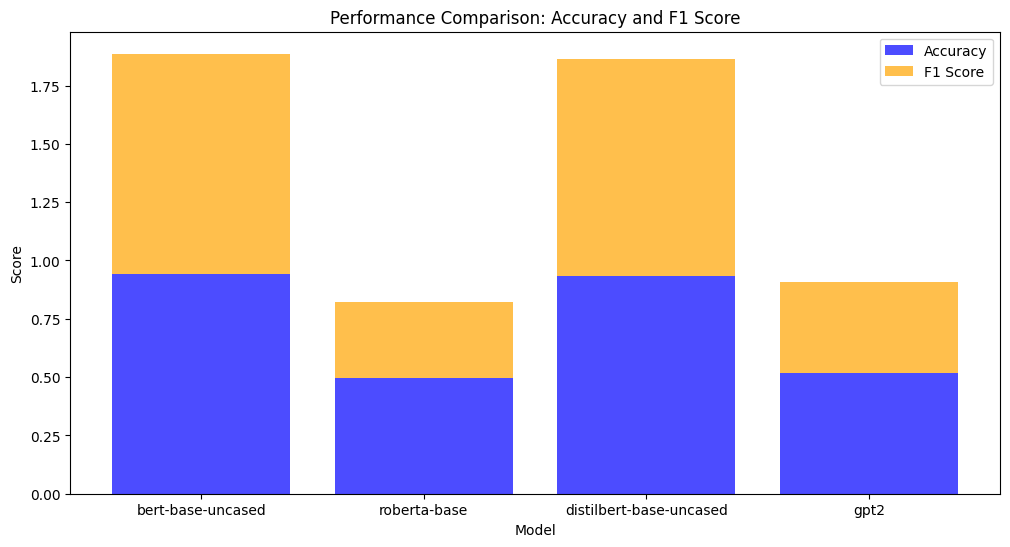

In [ ]:
# Plot Accuracy and F1 Scores
plt.figure(figsize=(12, 6))
plt.bar(model_names, accuracies, color='blue', alpha=0.7, label="Accuracy")
plt.bar(model_names, f1_scores, color='orange', alpha=0.7, label="F1 Score", bottom=accuracies)
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.title("Performance Comparison: Accuracy and F1 Score")
plt.show()

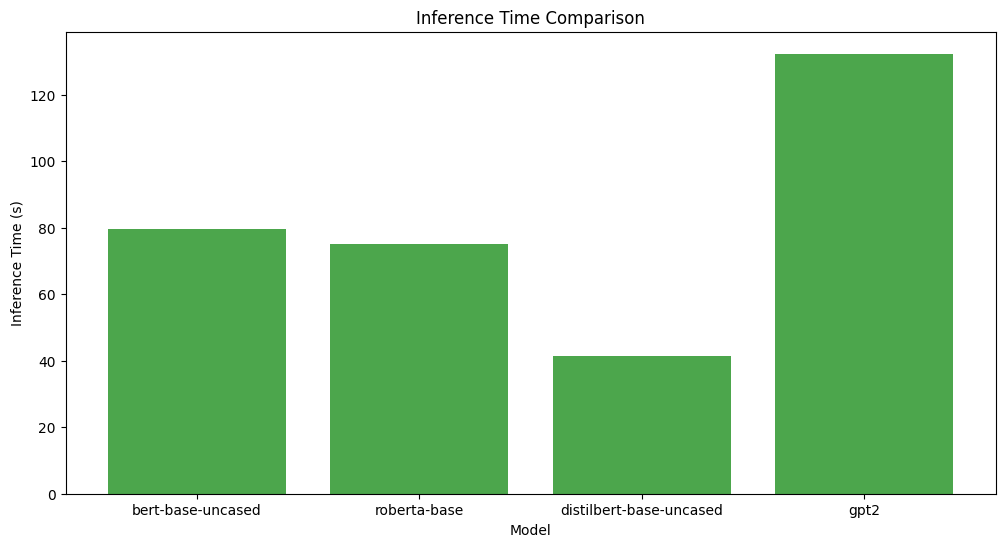

In [ ]:
# Plot Inference Time
plt.figure(figsize=(12, 6))
plt.bar(model_names, times, color='green', alpha=0.7)
plt.xlabel("Model")
plt.ylabel("Inference Time (s)")
plt.title("Inference Time Comparison")
plt.show()

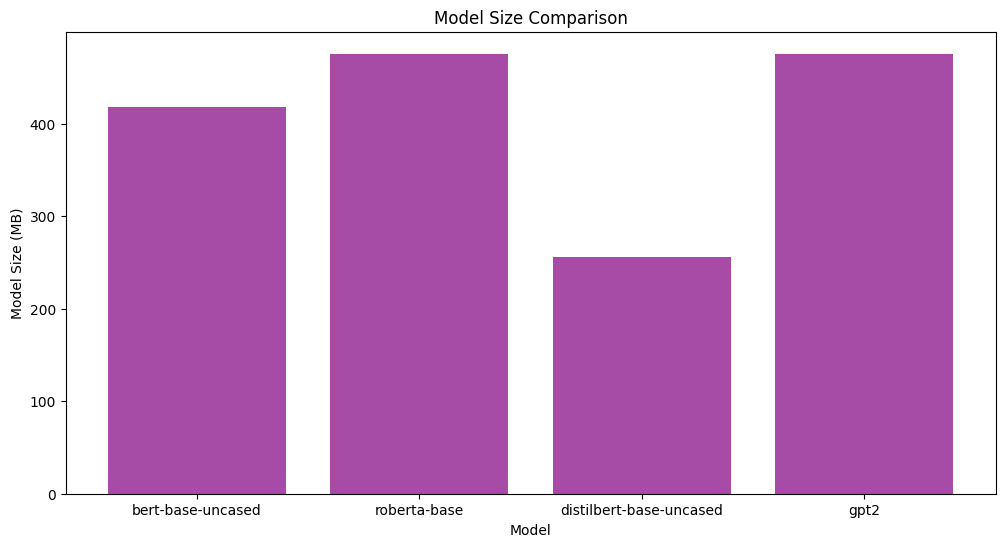

In [ ]:
# Plot Model Sizes
plt.figure(figsize=(12, 6))
plt.bar(model_names, sizes, color='purple', alpha=0.7)
plt.xlabel("Model")
plt.ylabel("Model Size (MB)")
plt.title("Model Size Comparison")
plt.show()